link: https://github.com/ginofft/NetVLAD
author: Nguyen Tuan Nghia

In [1]:
# !source activate nthlongcv3d

# import

In [1]:
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision.models import VGG16_Weights

from scr.netvlad import NetVLADLayer
from scr.dataset import OnlineTripletImageDataset, ImageDataset
from scr.loss import OnlineTripletLoss
# from scr.utils import save_checkpoint, load_checkpoint, plot_retrievals_images, str2bool
from scr.utils import save_checkpoint, load_checkpoint, str2bool
from scr.train import train, validate
from scr.query import query, calculate_netvlads

/data/computervision/anaconda3/envs/nthlongcv3d/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libc10_cuda.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


# Setup

In [2]:
from GPUtil import showUtilization as gpu_usage
gpu_usage()   

| ID | GPU | MEM |
------------------
|  0 |  0% | 52% |
|  1 |  0% | 30% |


In [3]:
cuda = torch.cuda.is_available()
if cuda:
    device =  torch.device("cuda")
else:
    print("No GPU found, please get one")
    device =  torch.device("cpu")
    

No GPU found, please get one


In [41]:
# import pycuda.driver as cuda
# cuda.init()
## Get Id of default device
torch.cuda.current_device()

AssertionError: Torch not compiled with CUDA enabled

In [13]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [4]:
encoder = models.vgg16(weights=None)
encoder_k = 512 ##TODO
layers = list(encoder.features.children())[:-2]

model = nn.Module()
encoder = nn.Sequential(*layers)
model.add_module('encoder', encoder)

n_vocabs = 16
net_vlad = NetVLADLayer(n_vocabs = n_vocabs, k = encoder_k)
model.add_module('netvlad', net_vlad)

model = model.to(device)

# Init Train

In [33]:
trainPath = 'data/train'
train_set = OnlineTripletImageDataset(Path(trainPath))

validationPath = 'data/validation'
val_set = OnlineTripletImageDataset(Path(validationPath))

savePath = 'model/BatchAll'

In [34]:
startEpoch = 0
val_loss = 1
train_loss = 1
nEpochs =100
margin = 0.1**0.5

criterion = OnlineTripletLoss(margin = margin, hard=False).to(device) #tiêu chuẩn

## Train epochs with savepoints

In [14]:
P = 4
K = 8
saveEvery = 25
lr = 0.001
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                             lr = lr)

for epoch in range(startEpoch+1, nEpochs+1):
      # train & validate
      epoch_train_loss = train(device, model, epoch,
                            train_set, P, K,
                            criterion, optimizer)  
      if validationPath:
        epoch_val_loss = validate(device, model, 
                                  val_set, P, K,
                                  criterion)
      else:
        epoch_val_loss = 1
 

      #saving stuff
      if (epoch_train_loss < train_loss): #lowest loss on train set
        train_loss = epoch_train_loss
        save_checkpoint({
            'epoch': epoch,
            'train_loss': epoch_train_loss,
            'val_loss': epoch_val_loss,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }, Path(savePath), 'best_train.pth.tar')

      if (epoch_val_loss < val_loss): #lowest loss on val set
        val_loss = epoch_val_loss
        save_checkpoint({
            'epoch': epoch,
            'train_loss': epoch_train_loss,
            'val_loss': epoch_val_loss,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }, Path(savePath), 'best.pth.tar')
        
      if (epoch % saveEvery) == 0: #save every epoch
        save_checkpoint({
            'epoch': epoch,
            'train_loss': epoch_train_loss,
            'val_loss': epoch_val_loss,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }, Path(savePath), 'epoch{}.pth.tar'.format(epoch))

Epoch[1](50/215): Loss: 0.3160
Epoch[1](100/215): Loss: 0.3151
Epoch[1](150/215): Loss: 0.3129
Epoch[1](200/215): Loss: 0.3105
---> Epoch 1 compledted: Train Avg. Loss: 0.3164
----> Validation loss: 0.3126
Epoch[2](50/215): Loss: 0.4356
Epoch[2](100/215): Loss: 0.3116
Epoch[2](150/215): Loss: 0.3157
Epoch[2](200/215): Loss: 0.3160
---> Epoch 2 compledted: Train Avg. Loss: 0.3190
----> Validation loss: 0.3152
Epoch[3](50/215): Loss: 0.3158
Epoch[3](100/215): Loss: 0.3142
Epoch[3](150/215): Loss: 0.3157
Epoch[3](200/215): Loss: 0.3125
---> Epoch 3 compledted: Train Avg. Loss: 0.3197
----> Validation loss: 0.3152
Epoch[4](50/215): Loss: 0.3117
Epoch[4](100/215): Loss: 0.3160
Epoch[4](150/215): Loss: 0.3144
Epoch[4](200/215): Loss: 0.3010
---> Epoch 4 compledted: Train Avg. Loss: 0.3133
----> Validation loss: 0.3106
Epoch[5](50/215): Loss: 0.2948
Epoch[5](100/215): Loss: 0.2661
Epoch[5](150/215): Loss: 0.2898
Epoch[5](200/215): Loss: 0.2736
---> Epoch 5 compledted: Train Avg. Loss: 0.3029


Epoch[40](100/215): Loss: 0.2379
Epoch[40](150/215): Loss: 0.2856
Epoch[40](200/215): Loss: 0.2995
---> Epoch 40 compledted: Train Avg. Loss: 0.2746
----> Validation loss: 0.2967
Epoch[41](50/215): Loss: 0.2809
Epoch[41](100/215): Loss: 0.2097
Epoch[41](150/215): Loss: 0.2468
Epoch[41](200/215): Loss: 0.2874
---> Epoch 41 compledted: Train Avg. Loss: 0.2734
----> Validation loss: 0.3066
Epoch[42](50/215): Loss: 0.2521
Epoch[42](100/215): Loss: 0.2998
Epoch[42](150/215): Loss: 0.2998
Epoch[42](200/215): Loss: 0.2880
---> Epoch 42 compledted: Train Avg. Loss: 0.2770
----> Validation loss: 0.2898
Epoch[43](50/215): Loss: 0.2670
Epoch[43](100/215): Loss: 0.2496
Epoch[43](150/215): Loss: 0.2924
Epoch[43](200/215): Loss: 0.3234
---> Epoch 43 compledted: Train Avg. Loss: 0.2717
----> Validation loss: 0.2951
Epoch[44](50/215): Loss: 0.2530
Epoch[44](100/215): Loss: 0.2613
Epoch[44](150/215): Loss: 0.2987
Epoch[44](200/215): Loss: 0.2706
---> Epoch 44 compledted: Train Avg. Loss: 0.2637
----> V

Epoch[79](50/215): Loss: 0.1047
Epoch[79](100/215): Loss: 0.0778
Epoch[79](150/215): Loss: 0.0730
Epoch[79](200/215): Loss: 0.0530
---> Epoch 79 compledted: Train Avg. Loss: 0.0775
----> Validation loss: 0.2129
Epoch[80](50/215): Loss: 0.0400
Epoch[80](100/215): Loss: 0.0914
Epoch[80](150/215): Loss: 0.0000
Epoch[80](200/215): Loss: 0.0028
---> Epoch 80 compledted: Train Avg. Loss: 0.0575
----> Validation loss: 0.2081
Epoch[81](50/215): Loss: 0.1043
Epoch[81](100/215): Loss: 0.0276
Epoch[81](150/215): Loss: 0.0952
Epoch[81](200/215): Loss: 0.0000
---> Epoch 81 compledted: Train Avg. Loss: 0.0592
----> Validation loss: 0.1915
Epoch[82](50/215): Loss: 0.0000
Epoch[82](100/215): Loss: 0.0000
Epoch[82](150/215): Loss: 0.0000
Epoch[82](200/215): Loss: 0.0657
---> Epoch 82 compledted: Train Avg. Loss: 0.0520
----> Validation loss: 0.1990
Epoch[83](50/215): Loss: 0.0435
Epoch[83](100/215): Loss: 0.0733
Epoch[83](150/215): Loss: 0.0160
Epoch[83](200/215): Loss: 0.0063
---> Epoch 83 compledted:

# Switch to BatchHard, train again

In [35]:
P = 4
K = 8
saveEvery = 25
lr = 0.001
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                             lr = lr)

In [36]:
loadPath = 'model/BatchAll/best.pth.tar'
startEpoch, train_loss, val_loss = load_checkpoint(Path(loadPath),
                                                        device,
                                                        model, 
                                                        optimizer)

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [15]:
val_loss = 1
train_loss = 1
nEpochs = 99 + startEpoch

criterion = OnlineTripletLoss(margin = margin, hard=True).to(device)

In [11]:
for epoch in range(startEpoch+1, nEpochs+1):
      # train & validate
      epoch_train_loss = train(device, model, epoch,
                            train_set, P, K,
                            criterion, optimizer)  
      if validationPath:
        epoch_val_loss = validate(device, model, 
                                  val_set, P, K,
                                  criterion)
      else:
        epoch_val_loss = 1
 

      #saving stuff
      if (epoch_train_loss < train_loss): #lowest loss on train set
        train_loss = epoch_train_loss
        save_checkpoint({
            'epoch': epoch,
            'train_loss': epoch_train_loss,
            'val_loss': epoch_val_loss,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }, Path(savePath), 'best_train.pth.tar')

      if (epoch_val_loss < val_loss): #lowest loss on val set
        val_loss = epoch_val_loss
        save_checkpoint({
            'epoch': epoch,
            'train_loss': epoch_train_loss,
            'val_loss': epoch_val_loss,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }, Path(savePath), 'best.pth.tar')
        
      if (epoch % saveEvery) == 0: #save every epoch
        save_checkpoint({
            'epoch': epoch,
            'train_loss': epoch_train_loss,
            'val_loss': epoch_val_loss,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }, Path(savePath), 'epoch{}.pth.tar'.format(epoch))

Epoch[95](50/215): Loss: 0.0000
Epoch[95](100/215): Loss: 0.0000
Epoch[95](150/215): Loss: 0.0000
Epoch[95](200/215): Loss: 0.0000
---> Epoch 95 compledted: Train Avg. Loss: 0.0003
----> Validation loss: 0.2017
Epoch[96](50/215): Loss: 0.0000
Epoch[96](100/215): Loss: 0.0000
Epoch[96](150/215): Loss: 0.0000
Epoch[96](200/215): Loss: 0.0000
---> Epoch 96 compledted: Train Avg. Loss: 0.0000
----> Validation loss: 0.2287
Epoch[97](50/215): Loss: 0.0000
Epoch[97](100/215): Loss: 0.0000
Epoch[97](150/215): Loss: 0.0000
Epoch[97](200/215): Loss: 0.0000
---> Epoch 97 compledted: Train Avg. Loss: 0.0000
----> Validation loss: 0.1632
Epoch[98](50/215): Loss: 0.0000
Epoch[98](100/215): Loss: 0.0000
Epoch[98](150/215): Loss: 0.0000
Epoch[98](200/215): Loss: 0.0000
---> Epoch 98 compledted: Train Avg. Loss: 0.0001
----> Validation loss: 0.1921
Epoch[99](50/215): Loss: 0.0000
Epoch[99](100/215): Loss: 0.0000
Epoch[99](150/215): Loss: 0.0000
Epoch[99](200/215): Loss: 0.0000
---> Epoch 99 compledted:

Epoch[133](100/215): Loss: 0.7863
Epoch[133](150/215): Loss: 0.5474
Epoch[133](200/215): Loss: 0.7881
---> Epoch 133 compledted: Train Avg. Loss: 0.6366
----> Validation loss: 0.6497
Epoch[134](50/215): Loss: 0.4880
Epoch[134](100/215): Loss: 0.6315
Epoch[134](150/215): Loss: 0.5500
Epoch[134](200/215): Loss: 0.4902
---> Epoch 134 compledted: Train Avg. Loss: 0.5775
----> Validation loss: 0.5804
Epoch[135](50/215): Loss: 0.3596
Epoch[135](100/215): Loss: 0.5395
Epoch[135](150/215): Loss: 0.3470
Epoch[135](200/215): Loss: 0.3385
---> Epoch 135 compledted: Train Avg. Loss: 0.4752
----> Validation loss: 0.5018
Epoch[136](50/215): Loss: 0.3451
Epoch[136](100/215): Loss: 0.3349
Epoch[136](150/215): Loss: 0.5378
Epoch[136](200/215): Loss: 0.5308
---> Epoch 136 compledted: Train Avg. Loss: 0.4958
----> Validation loss: 0.5243
Epoch[137](50/215): Loss: 0.7926
Epoch[137](100/215): Loss: 1.0215
Epoch[137](150/215): Loss: 0.3268
Epoch[137](200/215): Loss: 0.5324
---> Epoch 137 compledted: Train A

Epoch[171](100/215): Loss: 0.3165
Epoch[171](150/215): Loss: 0.3166
Epoch[171](200/215): Loss: 0.3165
---> Epoch 171 compledted: Train Avg. Loss: 0.3273
----> Validation loss: 0.3166
Epoch[172](50/215): Loss: 0.3166
Epoch[172](100/215): Loss: 0.3167
Epoch[172](150/215): Loss: 0.3866
Epoch[172](200/215): Loss: 0.3166
---> Epoch 172 compledted: Train Avg. Loss: 0.3264
----> Validation loss: 0.3166
Epoch[173](50/215): Loss: 0.3166
Epoch[173](150/215): Loss: 0.3166
Epoch[173](200/215): Loss: 0.3166
---> Epoch 173 compledted: Train Avg. Loss: 0.3312
----> Validation loss: 0.3167
Epoch[174](50/215): Loss: 0.3166
Epoch[174](100/215): Loss: 0.3166
Epoch[174](150/215): Loss: 0.3165
Epoch[174](200/215): Loss: 0.3165
---> Epoch 174 compledted: Train Avg. Loss: 0.3269
----> Validation loss: 0.3166
Epoch[175](50/215): Loss: 0.3166
Epoch[175](100/215): Loss: 0.3166
Epoch[175](150/215): Loss: 0.3166
Epoch[175](200/215): Loss: 0.3166
---> Epoch 175 compledted: Train Avg. Loss: 0.3282
----> Validation 

# Query

In [5]:
#Set up output paths
dbPath = 'data/database'
queryPath = 'data/query'
outPath = 'out'
query_features = Path(outPath) / 'q_features.h5'
db_features = Path(outPath) / 'db_features.h5'
retrieval = Path(outPath) / 'retrieved.h5'



In [6]:
#Load database into Dataset, then calculate db's netvlads
db_dataset = ImageDataset(Path(dbPath))
loadPath = 'model/BatchAll/best.pth.tar'

startEpoch, train_loss, val_loss = load_checkpoint(Path(loadPath), 
                                                        device,
                                                        model)
calculate_netvlads(device, model, db_dataset, db_features)

=> loaded checkpoint 'True' (epoch 130)
Checkpoint's train loss is: 0.0000
Checkpoint's validation loss is: 0.1581


KeyboardInterrupt: 

In [ ]:
#Load query into Dataset, then calculate query's netvlads
query_dataset = ImageDataset(Path(queryPath))
calculate_netvlads(device, model, query_dataset, query_features)

In [17]:
#Find Retrieval 
query(query_features, db_features, retrieval)
# plot_retrievals_images(retrieval, Path(dbPath), Path(queryPath))

# Query one image

In [6]:
db_dataset = ImageDataset(Path(dbPath))
loadPath = 'model/BatchAll/best.pth.tar'

startEpoch, train_loss, val_loss = load_checkpoint(Path(loadPath), 
                                                        device,
                                                        model)

=> loaded checkpoint 'True' (epoch 130)
Checkpoint's train loss is: 0.0000
Checkpoint's validation loss is: 0.1581


In [7]:
import urllib
import numpy as np
import cv2
from PIL import Image

req = urllib.request.urlopen('https://www.vaticancitytours.it/wp-content/uploads/2019/08/st-peters-square-outside.jpg')
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
opencv_image = cv2.imdecode(arr, -1)

rgb_image = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2RGB)
pil_image = Image.fromarray(rgb_image)

In [8]:
from scr.query_one import query_one, plot_retrieval_images_one

retrieved_dict = query_one(pil_image, device, model,
                      db_features,
                      n_result=10)

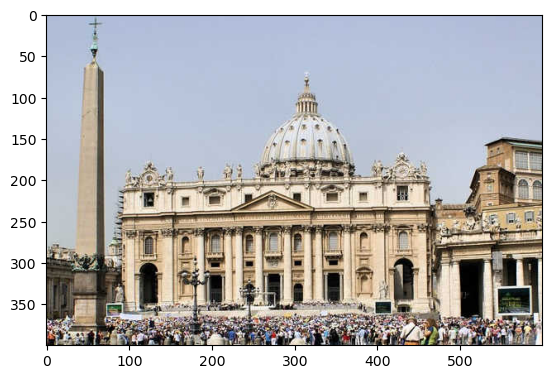

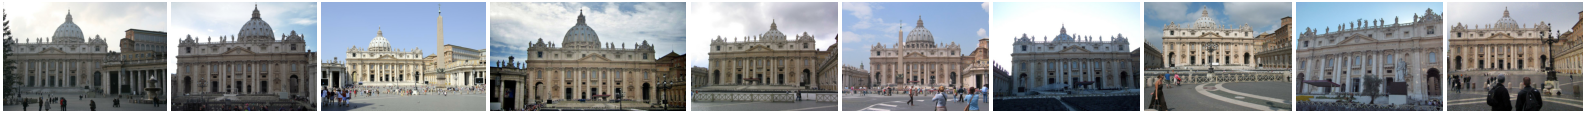

In [9]:
plot_retrieval_images_one(query_img = pil_image, retrieved_dict = retrieved_dict, db_dir = dbPath)